<a href="https://colab.research.google.com/github/thanaphornkanking/test/blob/main/%E0%B9%80%E0%B8%97%E0%B8%A3%E0%B8%99%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5%E0%B8%95%E0%B9%88%E0%B8%AD%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2_id14(300).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive # เชื่อมเข้ากับ Drive
drive.mount('/content/drive')  # คลิกที่ลิงก์ -> เลือก E-mail -> ลงชื่อเข้าใช้ -> ก็อปโค้ด -> นำกลับมาวางในช่องว่าง -> กด enter

Mounted at /content/drive


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [ ]:
batch_size = 20
width = 150
height = 150
epochs = 100
NUM_TRAIN = 100
NUM_TEST = 100
dropout_rate = 0.2
input_shape = (height, width, 3)

In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 75, 75, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 75, 75, 32)           0         ['batch_normaliz

In [ ]:
import pandas as pd
import shutil

In [ ]:
df = pd.read_csv (r'/content/drive/MyDrive/รูปรถทั้งหมด(old)/id_all_car992.csv')
df

,no,id,Degree,Part,Path_Name
0,1,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
1,2,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
2,3,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
3,4,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
4,5,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
...,...,...,...,...,...
200610,200611,id99,Severe,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id99/...
200611,200612,id99,Severe,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id99/...
200612,200613,id99,Severe,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id99/...
200613,200614,id99,Severe,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id99/...


In [ ]:
train = df[df['no'].between(0,147136)]
test = df[df['no'].between(147137,200615)]

In [ ]:
DATA_PATH = "/content/drive/My Drive/id"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'test')
print(test_dir)

/content/drive/My Drive/id/train
/content/drive/My Drive/id/test


In [ ]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test,
        directory = test_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

Found 142639 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4497 invalid image filename(s) in x_col="Path_Name". These filename(s) will be ignored.
  warnings.warn(


Found 53479 validated image filenames belonging to 15 classes.


#load model

In [ ]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Model/test/part_id14(200).h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
#load model
from tensorflow.keras.models import load_model
modeltwo = load_model('/content/drive/MyDrive/Model/test/part_id14(200).h5')
height = width = modeltwo.input_shape[1]

In [ ]:
modeltwo.summary()
modeltwo.get_weights()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 5, 5, 1280)        4049564   
 l)                                                              
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 15)                19215     
                                                                 
Total params: 4068779 (15.52 MB)
Trainable params: 4026763 (15.36 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


[array([[[[-4.24075246e-01, -3.22518521e-03, -6.90085530e-01,
           -6.00178003e-01, -8.90040621e-02, -2.86017030e-01,
           -2.11830333e-01,  1.12443626e-01, -8.98101330e-01,
            7.66852558e-01, -3.51023525e-01, -2.42335662e-01,
           -1.95182994e-01,  5.15837371e-01,  3.35890710e-01,
            4.13146406e-01, -3.72881681e-01,  7.47135580e-02,
            6.35886312e-01, -7.49256313e-02,  1.40187696e-01,
            6.51880354e-02, -6.60303235e-02, -3.84155065e-01,
           -4.43502724e-01,  4.16422859e-02, -2.36818334e-04,
           -1.72458783e-01,  5.56201756e-01, -1.26257259e-02,
           -4.90550846e-02,  4.19635952e-01],
          [-4.34261709e-01,  9.10604894e-02, -1.24963665e+00,
            1.12700038e-01, -3.16171169e-01, -3.34005654e-01,
           -4.81561720e-01, -1.45903423e-01, -1.68614900e+00,
            1.20944142e+00, -4.41536784e-01, -4.79129732e-01,
           -1.10543773e-01,  9.95173395e-01,  6.44293487e-01,
           -6.82860970e-

# Training

In [ ]:
modeltwo.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = modeltwo.fit(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=test_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)


Epoch 1/100
5/5 [==============================] - 76s 9s/step - loss: 0.6485 - acc: 0.6700 - val_loss: 1.5343 - val_acc: 0.4800
Epoch 2/100
5/5 [==============================] - 60s 9s/step - loss: 0.5096 - acc: 0.7000 - val_loss: 1.6419 - val_acc: 0.4900
Epoch 3/100
5/5 [==============================] - 46s 6s/step - loss: 0.6091 - acc: 0.6800 - val_loss: 2.4633 - val_acc: 0.4000
Epoch 4/100
5/5 [==============================] - 55s 9s/step - loss: 0.5349 - acc: 0.6900 - val_loss: 2.4722 - val_acc: 0.4200
Epoch 5/100
5/5 [==============================] - 38s 7s/step - loss: 0.5567 - acc: 0.6400 - val_loss: 2.4995 - val_acc: 0.3800
Epoch 6/100
5/5 [==============================] - 53s 10s/step - loss: 0.4886 - acc: 0.7100 - val_loss: 2.4174 - val_acc: 0.4800
Epoch 7/100
5/5 [==============================] - 61s 9s/step - loss: 0.5289 - acc: 0.6600 - val_loss: 2.3383 - val_acc: 0.3900
Epoch 8/100
5/5 [==============================] - 59s 10s/step - loss: 0.6326 - acc: 0.6400 - v

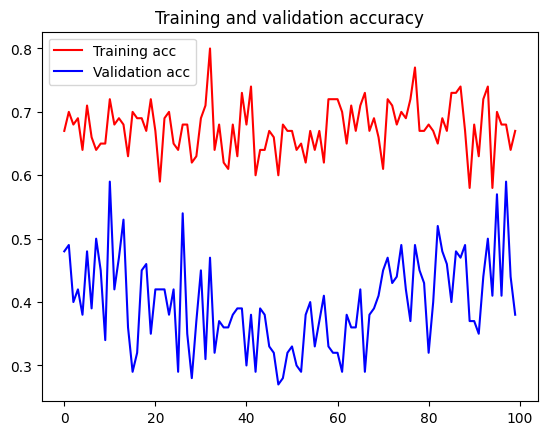

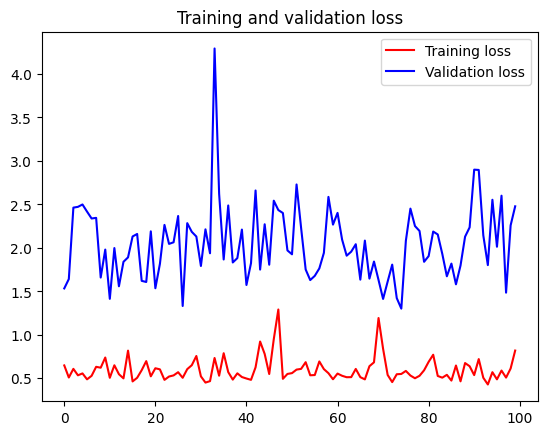

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'r', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# save model

In [ ]:
os.makedirs('/content/drive/MyDrive/Model/test', exist_ok=True)
modeltwo.save('/content/drive/MyDrive/Model/test/part_id14(300).h5')